# Praca domowa 2

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['figure.figsize'] = (16,6)
sns.set_style("ticks",{'axes.grid' : True})

## Zadanie klasyfikacji - airline passenger satisfaction

In [4]:
df_train = pd.read_csv('../data/airline_passenger_satisfaction/train.csv', index_col=0)
df_test = pd.read_csv('../data/airline_passenger_satisfaction/test.csv', index_col=0)

### Przygotowanie danych do modelu
* usunięcie niepotrzebnej kolumny `id`
* kolumny o wartościach binarnych: `Gender`, `Customer Type`, `Type of Travel`, `satisfaction` - sprowadzenie do postaci 0/1
* kodowanie OneHot kolumny `Class`
* kolumna `Arrival Delay in Minutes` - zastąpienie braków danych medianą (ze względu na wartości odstające), zmiana typu na *int*
* zlogarytmowanie kolumn ze względu na dużą skośność - `Departure`/`Arrival` `Delay in Minutes`
* *hipoteza* - kilkanaście kolumn zawiera oceny poszczególnych elementów lotu przyznane przez pasażerów; wartości należą do zbioru od 1 do 5; jednak ułamek obserwacji zawiera to zera - wydaje się, że to nie oznacza to najsłabszej oceny 0, tylko niewypełnione pole; zamienieniamy te pola na modę wartości w kolumnie

In [7]:
class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, rating_remove_zeros=True):
        self.rating_remove_zeros = rating_remove_zeros
        
        self.__rating_cols = ['Inflight wifi service',
           'Departure/Arrival time convenient', 'Ease of Online booking',
           'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
           'Inflight entertainment', 'On-board service', 'Leg room service',
           'Baggage handling', 'Checkin service', 'Inflight service',
           'Cleanliness']

    def transform(self, X, y=None):
        tmp = X.copy()
        # binarne -> 0/1
        tmp['Gender'] = (tmp['Gender'] == 'Male').astype(int)
        tmp['Customer Type'] = (tmp['Customer Type'] == 'Loyal Customer').astype(int)
        tmp['Type of Travel'] = (tmp['Type of Travel'] == 'Business travel').astype(int)
        tmp['satisfaction'] = (tmp['satisfaction'] == 'satisfied').astype(int)
        # OneHot 'Class'
        tmp =  pd.concat([pd.get_dummies(tmp[["Class"]]), tmp], axis=1)
        # 'Arrival' -> fill na, to int
        tmp.loc[tmp['Arrival Delay in Minutes'].isna(), 'Arrival Delay in Minutes'] = tmp['Arrival Delay in Minutes'].median()
        tmp['Arrival Delay in Minutes'] = tmp['Arrival Delay in Minutes'].astype(int)
        # log
        tmp['Departure Delay in Minutes'] = np.log1p(tmp['Departure Delay in Minutes'])
        tmp['Arrival Delay in Minutes'] = np.log1p(tmp['Arrival Delay in Minutes'])
        # Drop
        tmp = tmp.drop(['id', 'Class'], axis=1)
        # Replace 0 with mode - ratings cols
        if self.rating_remove_zeros:
            for col in self.__rating_cols:
                tmp.loc[tmp[col] == 0, col] = tmp.loc[tmp[col] != 0, col].mode()[0]
        
        return tmp

    def fit(self, X, y=None):
        return self

In [8]:
# df_train = Transformer(rating_remove_zeros=False).fit_transform(df_train)
# df_test = Transformer(rating_remove_zeros=False).fit_transform(df_test)
df_train = Transformer().fit_transform(df_train)
df_test = Transformer().fit_transform(df_test)

### Podział danych na zbiory: testowy, walidacyjny, treningowy
Dostępne są dwie ramki danych, `train.csv` i `test.csv`. Okazuje się bardzo przyjemenie, że `test.csv` to 20% wszystkich obserwacji. Wydzielimy jeszcze zbiór walidacyjny z treningowego tak, aby zawierał on 10% danych.

In [9]:
y_train_val = df_train['satisfaction']
X_train_val = df_train.drop('satisfaction', axis = 1)

y_test = df_test['satisfaction']
X_test = df_test.drop('satisfaction', axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.125, stratify=y_train_val)

### RandomForest

#### Wartości domyślne

In [11]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9462580843855867

In [12]:
clf.score(X_val, y_val)

0.9559593470896212

**Uwaga.** Wykonanie poniższych komórek może *chwilkę* zająć.

#### `n_estimators`
Domyślna liczba estymatorów (100) zdaje się być całkiem dobrym wyborem. Dla bardzo małej liczby estymatorów model zdecydowanie traci.

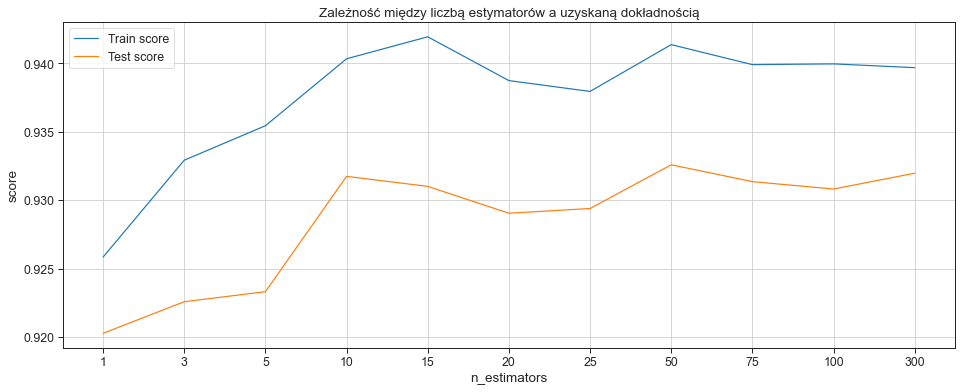

In [393]:
history = []

for n_estimators in [1, 3, 5, 10, 15, 20, 25, 50, 75, 100, 300]:
    clf = RandomForestClassifier(max_depth=10, n_estimators=n_estimators).fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    history.append((n_estimators, score_train, score_test))
    
history_df = pd.DataFrame.from_records(history, columns=['n_estimators', 'score_train', 'score_test'])
history_df['n_estimators'] = history_df['n_estimators'].astype(str)

fig, ax = plt.subplots()
sns.lineplot(data=history_df, x='n_estimators', y='score_train', ax=ax, label='Train score')
sns.lineplot(data=history_df, x='n_estimators', y='score_test', ax=ax, label='Test score')
plt.title('Zależność między liczbą estymatorów a uzyskaną dokładnością')
plt.ylabel('score')
plt.show()

#### `max_depth`
Wydaje się, że lepiej ograniczyć maksymalną głębokość drzew do około 10-20. Przy większej czy też nieogranicznoej głębokości model zdaje się za bardzo dopasowywać.

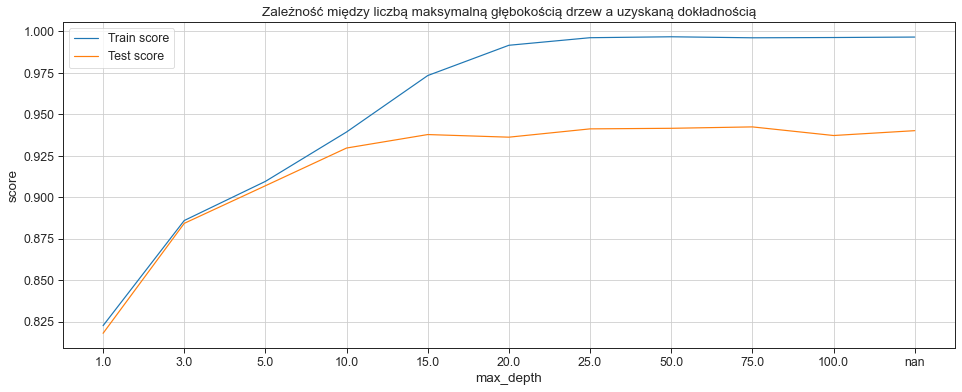

In [394]:
history = []

for max_depth in [1, 3, 5, 10, 15, 20, 25, 50, 75, 100, None]:
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=10).fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    history.append((max_depth, score_train, score_test))
    
history_df = pd.DataFrame.from_records(history, columns=['max_depth', 'score_train', 'score_test'])
history_df['max_depth'] = history_df['max_depth'].astype(str)

fig, ax = plt.subplots()
sns.lineplot(data=history_df, x='max_depth', y='score_train', ax=ax, label='Train score')
sns.lineplot(data=history_df, x='max_depth', y='score_test', ax=ax, label='Test score')
plt.title('Zależność między liczbą maksymalną głębokością drzew a uzyskaną dokładnością')
plt.ylabel('score')
plt.show()

#### `min_samples_split` oraz `max_features`
Domyślna wartość `max_features` czyli pierwiastek z liczby zmiennych, wydaje się być dobrym pomysłem. Przy większych wartościach model za bardzo się dopasowuje.

Natomiast co do `min_samples_split` to wydaje się, że im więcej, tym lepiej się model generalizuje. Zapewne gdyby była to zbyt duża wartość, to model by się nie dopasował. 

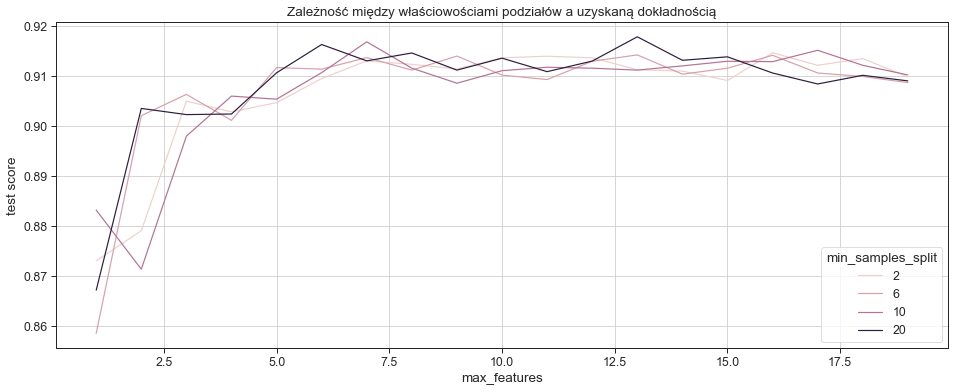

In [13]:
history = []

for max_features in range(1, 20, 1):
    for min_samples_split in [2, 6, 10, 20]:
        score = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=max_features, min_samples_split=min_samples_split).fit(X_train, y_train).score(X_test, y_test)
        history.append((max_features, min_samples_split, score))
    
history_df = pd.DataFrame.from_records(history, columns=['max_features', 'min_samples_split', 'score'])

sns.lineplot(data=history_df, x='max_features', y='score', hue='min_samples_split')
plt.title('Zależność między właściowościami podziałów a uzyskaną dokładnością')
plt.ylabel('test score')
plt.show()

#### `min_samples_leaf` oraz `max_leaf_nodes`
Problematyczne jest to, że te dwa hiperparametry zależą od siebie. Gdy ustawimy `max_leaf_nodes` na 100, to przy 100 tyś. wierszy będą liście o co najmniej 1000 obserwacji.

Duże czy nieograniczone `max_leaf_nodes` powoduje przefitowanie modelu. Podobnie przy za małym `min_samples_leaf`.

Dlatego trzeba nam szukać złotego środka. Największy wynik na zbiorze testowym został osiągnięty dla `max_leaf_nodes=200` i `min_samples_leaf=1`, choć jest to różnica marginalna. Możliwe też, że przy ponownym uruchomieniu się to zmieni.

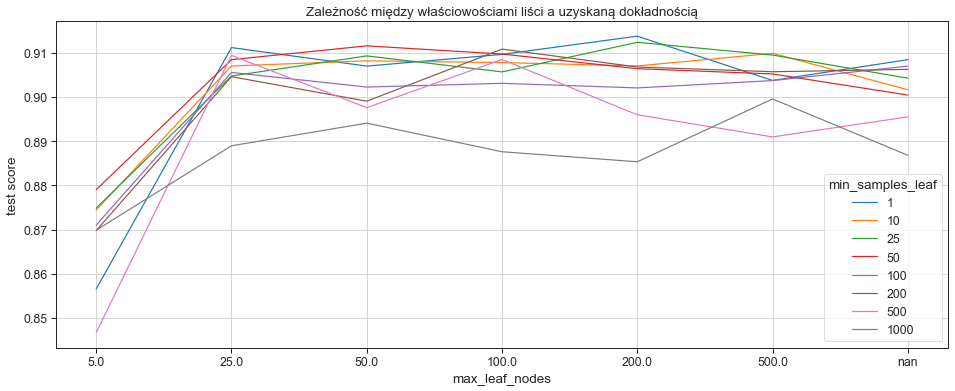

In [14]:
history = []

for max_leaf_nodes in [5, 25, 50, 100, 200, 500, None]:
    for min_samples_leaf in [1, 10, 25, 50, 100, 200, 500, 1000]:
        score = RandomForestClassifier(max_depth=5, n_estimators=10, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf).fit(X_train, y_train).score(X_test, y_test)
        history.append((max_leaf_nodes, min_samples_leaf, score))
    
history_df = pd.DataFrame.from_records(history, columns=['max_leaf_nodes', 'min_samples_leaf', 'score'])
history_df['max_leaf_nodes'] = history_df['max_leaf_nodes'].astype(str)
history_df['min_samples_leaf'] = history_df['min_samples_leaf'].astype(str)

sns.lineplot(data=history_df, x='max_leaf_nodes', y='score', hue='min_samples_leaf')
plt.title('Zależność między właściowościami liści a uzyskaną dokładnością')
plt.ylabel('test score')
plt.show()

### XGBoost

#### Wartości domyślne

In [9]:
cls = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False)
cls.fit(X_train, y_train, eval_metric="error", eval_set=[(X_val, y_val)], verbose=False)
cls.score(X_test, y_test)

0.9502232830304896

#### `n_estimators` a `learning_rate`
Dokumentacja (ale paczki [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) twierdzi, że modele oparte na drzewach wzmocnionych gradientowo są nawet odporne na zbytnie dopasowywanie. Po prostu wraz ze wzrostem liczby estymatorów wynik modelu będzie lepszy aż do pewnej wartości granicznej. 

Ponadto okazuje się, że `learning_rate` nie powinien być większy od 1, choć nie udało się znaleźć na ten temat wzmianki.

Teza odnośnie liczby estymatorów zdaje się być całkiem dobrze potwierdzona. Lepsze wyniki uzyskujemy dla większej liczby estymatrów, ale chyba nie ma potrzeby przekraczać 300.

Wysoki `learning_rate` dobrze sobie radzi dla małej liczby estymatorów. Jednak dla wielu estymatorów to najmniejszy z nich, równy 0.1, wysuwa się zdecydowanie na prowadzenie.

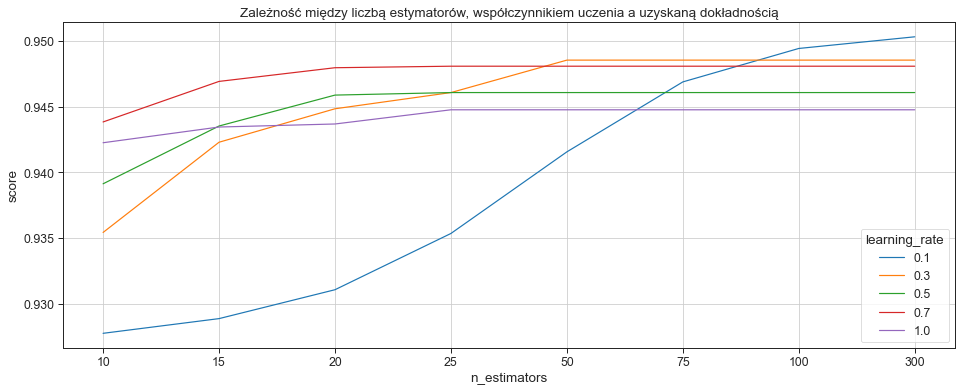

In [26]:
history = []

for n_estimators in [10, 15, 20, 25, 50, 75, 100, 300]:
    for learning_rate in [0.1, 0.3, 0.5, 0.7, 1]:
        cls = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, n_estimators=n_estimators, learning_rate=learning_rate)
        cls.fit(X_train, y_train, eval_metric="error", early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
        score = cls.score(X_test, y_test)
        history.append((n_estimators, learning_rate, score))
        
history_df = pd.DataFrame.from_records(history, columns=['n_estimators', 'learning_rate', 'score'])
history_df['n_estimators'] = history_df['n_estimators'].astype(str)
history_df['learning_rate'] = history_df['learning_rate'].astype(str)

sns.lineplot(data=history_df, x='n_estimators', y='score', hue='learning_rate')
plt.title('Zależność między liczbą estymatorów, współczynnikiem uczenia, a uzyskaną dokładnością')
plt.show()

#### `max_depth`
Bardzo ciekawe rzeczy dzieją się z parametrem `max_depth`. [Dokumentacja](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) twierdzi, że domyślna wartość to 6, natomiast 0 oznacza brak limitu głębokości. Spodziewalibyśmy się, że ustawienie zbyt dużej głębokości spowoduje zbyt duże dopasowanie modelu do danych testowych. I jak dla głębokości 1 model nie jest dopasowany, tak zarówno dla 6, jak i 1000 wynik wydaje się być bardzo podobny. Natomiast dla braku ograniczenia (0) score horrendalnie spada do poziomu blisko 0.55.  

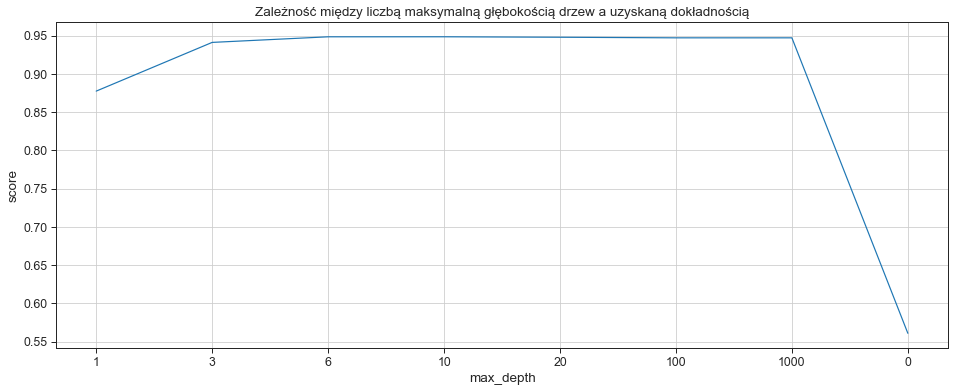

In [39]:
history = []

for max_depth in [1, 3, 6, 10, 20, 100 , 1000, 0]:
    cls = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, max_depth=max_depth)
    cls.fit(X_train, y_train, eval_metric="error", early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
    score = cls.score(X_test, y_test)
    history.append((max_depth, score))
    
history_df = pd.DataFrame.from_records(history, columns=['max_depth', 'score'])
history_df['max_depth'] = history_df['max_depth'].astype(str)

sns.lineplot(data=history_df, x='max_depth', y='score')
plt.title('Zależność między liczbą maksymalną głębokością drzew a uzyskaną dokładnością')
plt.show()

### Podsumowanie

Przy każdym zestawie hipermarametrów XGBoost zdaje się osiągać odrobinkę lepsze wyniki niż Random Forest.

Gdy chcemy osiągnąć dobrą generalizację modelu to wydaje się, że przede wszystkim powinniśmy zachowywać umiar. Sprawdze się to szczególnie przy ograniczaniu maksymalnej głębokości drzew `max_depth` - gdy ten parametr jest za duży, oba modele dopasowują się za bardzo. 

O zachowaniu umiaru możemy również mówić przy `max_features` i `max_leaf_nodes`.

Natomiast nigdy chyba nie zaszkodzi duża liczba estymatorów `n_estimators`. Modele raczej się nie przefitują, ale w pewnym momecie zyski z dalszego zwiększania staną się znikome. Natomiast za mała liczba estymatorów to skutkuje niedopasowaniem.

Ogólną generalizację modelów możemy poprawić jeszcze przez zwiększenie `min_samples_split`, `min_samples_leaf` oraz `learning_rate` (w przypadku XGB).

## Zadanie regresji - car prices poland
**Uwaga.** Dla zadań klasyfikacji i regresji najważniejsze hiperparamtery obydwu modeli nie różnią się chyba mocno, więc nie będziemy ich tak mocno analizować.

In [16]:
df = pd.read_csv('..\data\car_prices_poland\Car_Prices_Poland.csv', index_col=0)

### Przygotowanie danych do modelu
* usunięcie kolumny `generation_name`, ponieważ model prawie jednoznacznie wyznacza tą kolumnę; ponadto, ta kolumna zawiera dużo braków danych
* ucięcie wszystkich samochodów starszych niż 1995, poniważ stanowią one znikomą cześć obserwacji (ok. 200)
* ucięcie wszystkich samochodów o przebiegu (`mileage`) większym niż 400000, poniważ stanowią one znikomą cześć obserwacji (ok. 500)
* zaokrąglenie `vol_enigne` do pełnych setek; wartości większe niż 4000 sprowadzone do 4000, z przedziału [3000, 4000) do 3000; z przedziału (0, 1000] do 1000, 0 zastąpione medianą;
* dołączenie nielicznej kategorii paliwa *CNG* do *LPG*, bo to gaz i to gaz
* kodowanie OneHot kolumny `fuel`
* usunięcie nielicznych obserwacji z dziwną wartością województwa (`province`)
* podział miast (`city`) na trzy kategorie w zależności od częstości występowania w ramce danych
* usunięcie nielicznych obserwacji z ceną powyżej 500 tyś. (ok. 500)
* zakodowanie `mask`, `model`, `province` za pomocą `LabelEncoder` (czy tak powinno się robić? to nie są uporządkowane kategorie; jednak liczba występujących wartości skłania nas ku temu rozwiązaniu)

In [260]:
df = df.drop('generation_name', axis=1)
df = df[df['year'] > 1995]
df = df[df['mileage'] < 400000]

df['vol_engine'] = ((df['vol_engine'] / 100).round() * 100).astype(int)
df.loc[df['vol_engine'] > 4000, 'vol_engine'] = 4000
df.loc[((df['vol_engine'] >= 3000) & (df['vol_engine'] < 4000)), 'vol_engine'] = 3000
df.loc[((df['vol_engine'] > 0) & (df['vol_engine'] <= 1000)), 'vol_engine'] = 1000
df.loc[df['vol_engine'] == 0, 'vol_engine'] = df['vol_engine'].median()

df.loc[df['fuel'] == 'CNG', 'fuel'] = 'LPG'

df = pd.concat([pd.get_dummies(df[["fuel"]]), df], axis=1)
df = df.drop('fuel', axis=1)


df = df[~df['province'].isin(['Moravian-Silesian Region', 'Berlin', 'Wiedeń', 'Niedersachsen', '(',
       'Trenczyn', 'Nordrhein-Westfalen'])]

city_counts = df['city'].value_counts()
city_categories = pd.cut(city_counts, bins=[0, 100, 1000, np.inf], labels=[1, 2, 3])
df['city'] = df['city'].apply(lambda x: city_categories[x])

df = df[df['price'] < 500000]

label_encoder = LabelEncoder()
df.loc[:, ['mark', 'model', 'province']] = df[['mark', 'model', 'province']].apply(label_encoder.fit_transform)

### Podział danych na zbiory: testowy, walidacyjny, treningowy

In [262]:
y = df['price']
X = df.drop('price', axis=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.125)

### RandomForest

#### a.

In [325]:
regr = RandomForestRegressor(random_state=42)
regr = regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9457892021645453

In [326]:
mean_squared_error(y_test, regr.predict(X_test))

290856911.36060035

#### b. `max_depth=20`, `min_samples_split=10`

In [327]:
regr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_split=10)
regr = regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9456981291440012

In [328]:
mean_squared_error(y_test, regr.predict(X_test))

291345544.9635246

#### c. `max_depth=20`, `min_samples_split=10`, `min_smaples_leaf=5`

In [329]:
regr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_split=10, min_samples_leaf=5)
regr = regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9424621412728623

In [330]:
mean_squared_error(y_test, regr.predict(X_test))

308707573.839334

#### d. `max_depth=20`, `min_samples_split=10`, `min_smaples_leaf=5, max_leaf_nodes=1000`

In [331]:
regr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_split=10, min_samples_leaf=5, max_leaf_nodes=1000)
regr = regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.9372982693376525

In [332]:
mean_squared_error(y_test, regr.predict(X_test))

336413269.0459539

#### Wnioski
Wypróbowaliśmy kilka zestawów hiperparametrów, posiłkując się wcześniejszymi obserwacjami. Mimo to wyniki modelu różnią się bardzo nieznacznie, wręcz nasze próby generalizacji osłabiają dokładność i zwiększają błąd średniokwadratowy.

### XGBoost

#### a.

In [319]:
regr = xgb.XGBRegressor(objective="reg:squarederror", use_label_encoder=False)
regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)
regr.score(X_test, y_test)

0.9483600451309484

In [320]:
mean_squared_error(y_test, regr.predict(X_test))

277063580.9788788

#### b. `max_depth=3`

In [321]:
regr = xgb.XGBRegressor(objective="reg:squarederror", use_label_encoder=False, max_depth=3)
regr.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
regr.score(X_test, y_test)

0.9131513086722849

In [322]:
mean_squared_error(y_test, regr.predict(X_test))

465968831.3749294

#### c. `max_depth=10`, `n_estimators=300`

In [323]:
regr = xgb.XGBRegressor(objective="reg:squarederror", use_label_encoder=False, max_depth=10, n_estimators=300)
regr.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
regr.score(X_test, y_test)

0.9506936075147643

In [324]:
mean_squared_error(y_test, regr.predict(X_test))

264543330.87143523

#### Wnioski
Jak można było się spodziewać, zwiększając nieznacznie głębokość drzew oraz liczbę estymatorów otrzymaliśmy odrobinkę lepszy wynik.

### Podsumowanie
Tak samo jak dla zadania klasyfikacji, w zadaniu regresji odrobinkę lepiej sprawdzają się drzewa wzmocnione gradientowo.